# Notebook 01: Basic Widget Manufacturer Model

This notebook demonstrates the fundamental components of our widget manufacturer financial model, including:
- Balance sheet dynamics
- Revenue generation and profitability
- Insurance claims with deductibles and limits
- Letter of credit collateral management
- Key financial metrics (ROE, ROA, etc.)

In [1]:
# Setup and imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path().absolute().parent))

from src.config import ManufacturerConfig
from src.manufacturer import WidgetManufacturer
from src.claim_generator import ClaimGenerator, ClaimEvent

# Configure matplotlib for WSJ style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['grid.alpha'] = 0.3

# Set random seed for reproducibility
np.random.seed(42)

## 1. Initialize the Manufacturer

We start with a widget manufacturer with $10M in initial assets. Key parameters:
- **Asset Turnover Ratio**: 1.0 (generates $1 of revenue per $1 of assets)
- **Operating Margin**: 8% (typical for manufacturing)
- **Tax Rate**: 25%
- **Retention Ratio**: 100% (all earnings retained for growth)

In [2]:
# Create configuration
config = ManufacturerConfig(
    initial_assets=10_000_000,
    asset_turnover_ratio=1.0,
    operating_margin=0.08,
    tax_rate=0.25,
    retention_ratio=1.0
)

# Initialize manufacturer
manufacturer = WidgetManufacturer(config)

# Display initial state
print("Initial Balance Sheet:")
print("=" * 40)
print(f"Assets:            ${manufacturer.assets:,.0f}")
print(f"Restricted Assets: ${manufacturer.restricted_assets:,.0f}")
print(f"Available Assets:  ${manufacturer.available_assets:,.0f}")
print(f"Equity:            ${manufacturer.equity:,.0f}")
print(f"Collateral (LoC):  ${manufacturer.collateral:,.0f}")

Initial Balance Sheet:
Assets:            $10,000,000
Restricted Assets: $0
Available Assets:  $10,000,000
Equity:            $10,000,000
Collateral (LoC):  $0


## 2. Single Year Operations

Let's examine a single year of normal operations to understand the financial flows.

In [3]:
# Calculate one year of operations
revenue = manufacturer.calculate_revenue(working_capital_pct=0.2)
operating_income = manufacturer.calculate_operating_income(revenue)
net_income = manufacturer.calculate_net_income(operating_income, collateral_costs=0)

print("Annual Financial Performance:")
print("=" * 40)
print(f"Revenue:           ${revenue:,.0f}")
print(f"Operating Income:  ${operating_income:,.0f} ({manufacturer.operating_margin:.1%} margin)")
print(f"Net Income:        ${net_income:,.0f} (after {manufacturer.tax_rate:.0%} tax)")
print(f"\nReturn on Equity:  {net_income/manufacturer.equity:.1%}")
print(f"Return on Assets:  {net_income/manufacturer.assets:.1%}")

Annual Financial Performance:
Revenue:           $8,333,333
Operating Income:  $666,667 (8.0% margin)
Net Income:        $500,000 (after 25% tax)

Return on Equity:  5.0%
Return on Assets:  5.0%


## 3. Insurance Claim Processing

Now let's examine how insurance claims work with deductibles and limits:
- **Deductible**: Amount the company must pay before insurance kicks in
- **Insurance Limit**: Maximum amount the insurance will cover
- **Letter of Credit**: Required as collateral for insurance payments

In [4]:
# Reset manufacturer for claim demonstration
manufacturer.reset()

# Define insurance parameters
deductible = 1_000_000  # $1M deductible
insurance_limit = 10_000_000  # $10M limit

# Test different claim sizes
test_claims = [
    500_000,    # Below deductible
    3_000_000,  # Above deductible, below limit
    15_000_000, # Above limit
]

print("Insurance Claim Examples:")
print("=" * 60)
print(f"Deductible: ${deductible:,.0f}")
print(f"Insurance Limit: ${insurance_limit:,.0f}")
print("\n")

for claim_amount in test_claims:
    # Calculate coverage
    if claim_amount <= deductible:
        company_pays = claim_amount
        insurance_pays = 0
    else:
        company_pays = deductible
        insurance_pays = min(claim_amount - deductible, insurance_limit)
        if claim_amount > deductible + insurance_limit:
            company_pays += claim_amount - deductible - insurance_limit
    
    print(f"Claim: ${claim_amount:,.0f}")
    print(f"  Company pays:   ${company_pays:,.0f}")
    print(f"  Insurance pays: ${insurance_pays:,.0f}")
    print(f"  LoC Required:   ${insurance_pays:,.0f}")
    print()

Insurance Claim Examples:
Deductible: $1,000,000
Insurance Limit: $10,000,000


Claim: $500,000
  Company pays:   $500,000
  Insurance pays: $0
  LoC Required:   $0

Claim: $3,000,000
  Company pays:   $1,000,000
  Insurance pays: $2,000,000
  LoC Required:   $2,000,000

Claim: $15,000,000
  Company pays:   $5,000,000
  Insurance pays: $10,000,000
  LoC Required:   $10,000,000



## 4. Multi-Year Simulation with Claims

Let's simulate 10 years with periodic insurance claims to see how the business evolves.

In [5]:
# Reset and run simulation
manufacturer.reset()

# Insurance parameters
deductible = 1_000_000
insurance_limit = 10_000_000

# Track metrics
years = []
assets = []
equity = []
collateral = []
roe = []

# Initial state
years.append(0)
assets.append(manufacturer.assets)
equity.append(manufacturer.equity)
collateral.append(manufacturer.collateral)
roe.append(0)

# Simulate 10 years with claims in years 2 and 6
claim_schedule = {
    2: 5_000_000,   # $5M claim in year 2
    6: 12_000_000,  # $12M claim in year 6
}

for year in range(1, 11):
    # Process any scheduled claims
    if year in claim_schedule:
        claim_amount = claim_schedule[year]
        company_payment, insurance_payment = manufacturer.process_insurance_claim(
            claim_amount, deductible, insurance_limit
        )
        print(f"Year {year}: Claim ${claim_amount:,.0f} (Company: ${company_payment:,.0f}, Insurance: ${insurance_payment:,.0f})")
    
    # Run annual step
    metrics = manufacturer.step(working_capital_pct=0.2, letter_of_credit_rate=0.015, growth_rate=0.03)
    
    # Store metrics
    years.append(year)
    assets.append(metrics['assets'])
    equity.append(metrics['equity'])
    collateral.append(metrics['collateral'])
    roe.append(metrics['roe'])

# Create results dataframe
results_df = pd.DataFrame({
    'Year': years,
    'Assets': assets,
    'Equity': equity,
    'Collateral': collateral,
    'ROE': roe
})

Company became insolvent with equity: $-27,393.13


Year 2: Claim $5,000,000 (Company: $1,000,000, Insurance: $4,000,000)
Year 6: Claim $12,000,000 (Company: $2,000,000, Insurance: $10,000,000)


## 5. Visualize Financial Evolution

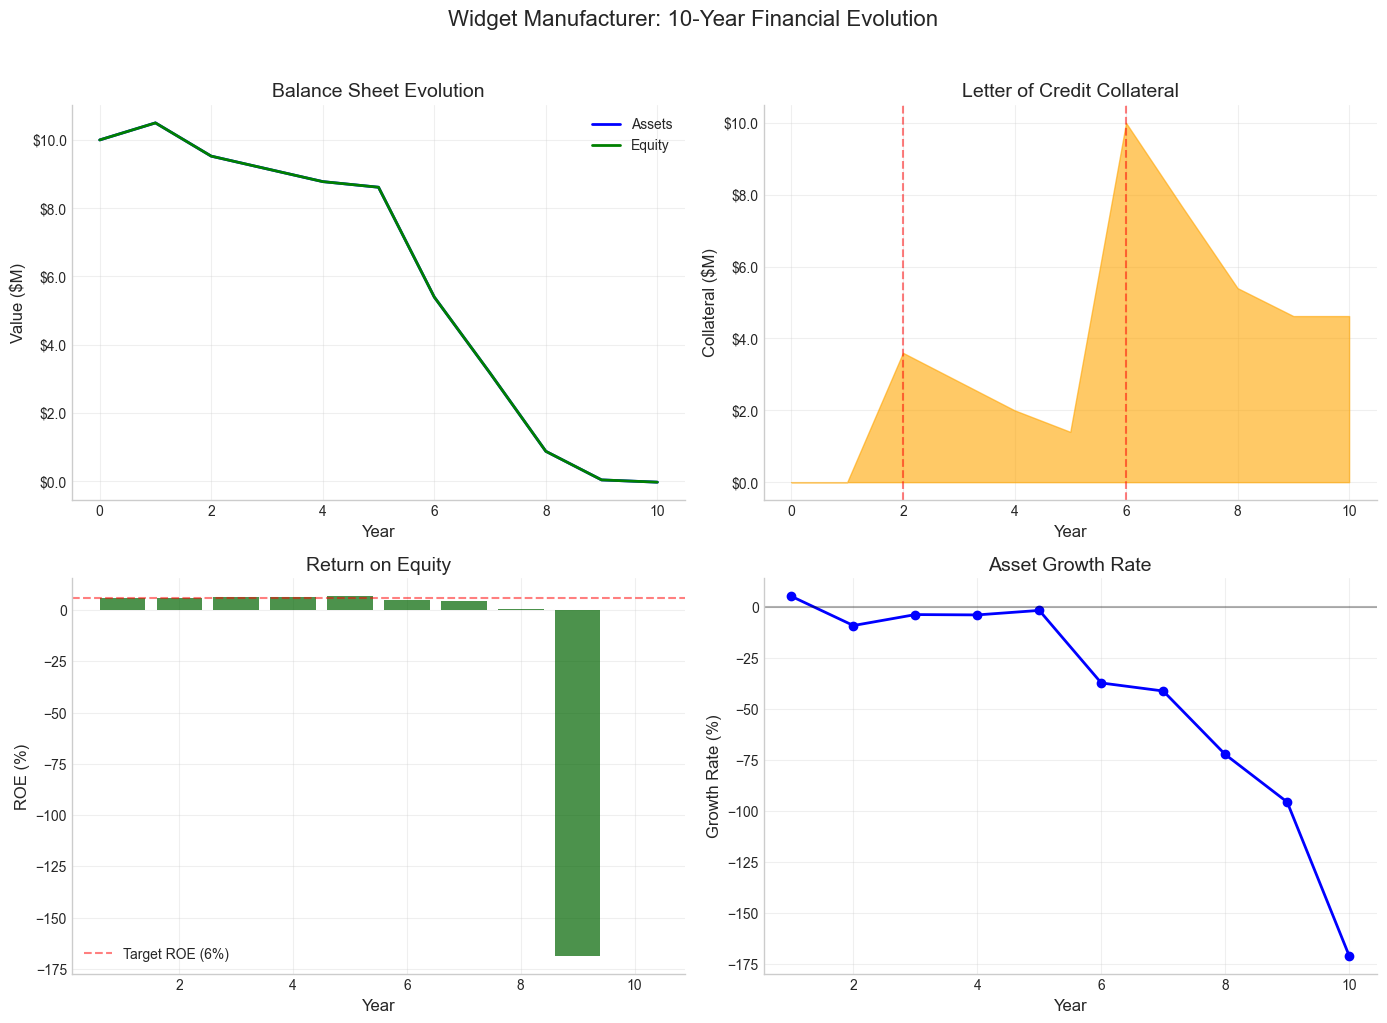

In [6]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Widget Manufacturer: 10-Year Financial Evolution', fontsize=16, y=1.02)

# Plot 1: Assets and Equity
ax1 = axes[0, 0]
ax1.plot(results_df['Year'], results_df['Assets']/1e6, 'b-', linewidth=2, label='Assets')
ax1.plot(results_df['Year'], results_df['Equity']/1e6, 'g-', linewidth=2, label='Equity')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value ($M)')
ax1.set_title('Balance Sheet Evolution')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('$%.1f'))

# Plot 2: Collateral
ax2 = axes[0, 1]
ax2.fill_between(results_df['Year'], 0, results_df['Collateral']/1e6, 
                  color='orange', alpha=0.6, label='LoC Collateral')
ax2.set_xlabel('Year')
ax2.set_ylabel('Collateral ($M)')
ax2.set_title('Letter of Credit Collateral')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('$%.1f'))

# Mark claim events
for year, amount in claim_schedule.items():
    ax2.axvline(x=year, color='red', linestyle='--', alpha=0.5, label=f'Claim Year {year}')

# Plot 3: Return on Equity
ax3 = axes[1, 0]
ax3.bar(results_df['Year'][1:], results_df['ROE'][1:]*100, color='darkgreen', alpha=0.7)
ax3.axhline(y=6, color='red', linestyle='--', alpha=0.5, label='Target ROE (6%)')
ax3.set_xlabel('Year')
ax3.set_ylabel('ROE (%)')
ax3.set_title('Return on Equity')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: Asset Growth Rate
ax4 = axes[1, 1]
asset_growth = results_df['Assets'].pct_change()[1:] * 100
ax4.plot(results_df['Year'][1:], asset_growth, 'b-', linewidth=2, marker='o')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.set_xlabel('Year')
ax4.set_ylabel('Growth Rate (%)')
ax4.set_title('Asset Growth Rate')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Key Financial Metrics Summary

In [7]:
# Calculate summary statistics
print("Financial Performance Summary (10 Years):")
print("=" * 50)
print(f"Initial Assets:        ${results_df['Assets'].iloc[0]:,.0f}")
print(f"Final Assets:          ${results_df['Assets'].iloc[-1]:,.0f}")
print(f"Asset CAGR:            {((results_df['Assets'].iloc[-1]/results_df['Assets'].iloc[0])**(1/10) - 1)*100:.1f}%")
print()
print(f"Initial Equity:        ${results_df['Equity'].iloc[0]:,.0f}")
print(f"Final Equity:          ${results_df['Equity'].iloc[-1]:,.0f}")
print(f"Equity CAGR:           {((results_df['Equity'].iloc[-1]/results_df['Equity'].iloc[0])**(1/10) - 1)*100:.1f}%")
print()
print(f"Average ROE:           {results_df['ROE'][1:].mean()*100:.1f}%")
print(f"Std Dev ROE:           {results_df['ROE'][1:].std()*100:.1f}%")
print(f"Max Collateral:        ${results_df['Collateral'].max():,.0f}")
print(f"Total Claims:          ${sum(claim_schedule.values()):,.0f}")

Financial Performance Summary (10 Years):
Initial Assets:        $10,000,000
Final Assets:          $-27,393
Asset CAGR:            nan%

Initial Equity:        $10,000,000
Final Equity:          $-27,393
Equity CAGR:           nan%

Average ROE:           -12.7%
Std Dev ROE:           54.8%
Max Collateral:        $10,000,000
Total Claims:          $17,000,000


C:\Users\alexf\AppData\Local\Temp\ipykernel_38800\1829094061.py:6: RuntimeWarning: invalid value encountered in scalar power
  print(f"Asset CAGR:            {((results_df['Assets'].iloc[-1]/results_df['Assets'].iloc[0])**(1/10) - 1)*100:.1f}%")
C:\Users\alexf\AppData\Local\Temp\ipykernel_38800\1829094061.py:10: RuntimeWarning: invalid value encountered in scalar power
  print(f"Equity CAGR:           {((results_df['Equity'].iloc[-1]/results_df['Equity'].iloc[0])**(1/10) - 1)*100:.1f}%")


## 7. Sensitivity Analysis: Deductible Impact

Let's analyze how different deductible levels affect the company's financial performance.

Company became insolvent with equity: $-31,426.90
Company became insolvent with equity: $-33,683.13
Company became insolvent with equity: $-35,939.37
Company became insolvent with equity: $-40,451.83
Company became insolvent with equity: $-54,971.65
Company is already insolvent, skipping step
Company is already insolvent, skipping step


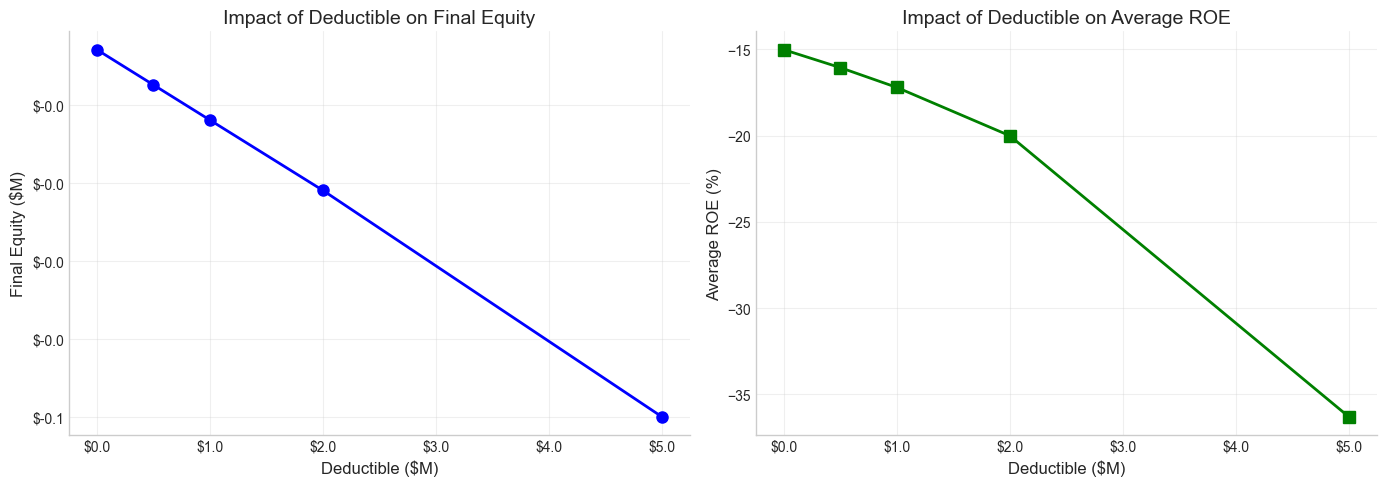


Deductible Sensitivity Analysis:
 Deductible  Final_Assets  Final_Equity  Max_Collateral  Avg_ROE
          0        -31427        -31427        10250000      -15
     500000        -33683        -33683        10125000      -16
    1000000        -35939        -35939        10000000      -17
    2000000        -40452        -40452         9750000      -20
    5000000        -54972        -54972         6300000      -36


In [8]:
# Test different deductible levels
deductibles = [0, 500_000, 1_000_000, 2_000_000, 5_000_000]
insurance_limit = 10_000_000

deductible_results = []

for deductible in deductibles:
    # Reset manufacturer
    manufacturer.reset()
    
    # Run 10 years with same claim schedule
    for year in range(1, 11):
        if year in claim_schedule:
            claim_amount = claim_schedule[year]
            manufacturer.process_insurance_claim(claim_amount, deductible, insurance_limit)
        
        metrics = manufacturer.step(working_capital_pct=0.2, letter_of_credit_rate=0.015)
    
    # Store final results
    deductible_results.append({
        'Deductible': deductible,
        'Final_Assets': manufacturer.assets,
        'Final_Equity': manufacturer.equity,
        'Max_Collateral': max([m['collateral'] for m in manufacturer.metrics_history]),
        'Avg_ROE': np.mean([m['roe'] for m in manufacturer.metrics_history]) * 100
    })

# Create dataframe
deductible_df = pd.DataFrame(deductible_results)

# Visualize deductible impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Final Equity vs Deductible
ax1 = axes[0]
ax1.plot(deductible_df['Deductible']/1e6, deductible_df['Final_Equity']/1e6, 
         'b-', linewidth=2, marker='o', markersize=8)
ax1.set_xlabel('Deductible ($M)')
ax1.set_ylabel('Final Equity ($M)')
ax1.set_title('Impact of Deductible on Final Equity')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('$%.1f'))
ax1.xaxis.set_major_formatter(mticker.FormatStrFormatter('$%.1f'))

# Plot 2: Average ROE vs Deductible
ax2 = axes[1]
ax2.plot(deductible_df['Deductible']/1e6, deductible_df['Avg_ROE'], 
         'g-', linewidth=2, marker='s', markersize=8)
ax2.set_xlabel('Deductible ($M)')
ax2.set_ylabel('Average ROE (%)')
ax2.set_title('Impact of Deductible on Average ROE')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter('$%.1f'))

plt.tight_layout()
plt.show()

# Print summary table
print("\nDeductible Sensitivity Analysis:")
print("=" * 70)
print(deductible_df.to_string(index=False, float_format='%.0f'))

## 8. Model Assumptions and Limitations

### Key Assumptions:
1. **Deterministic Growth**: Revenue grows at a fixed rate (no volatility)
2. **Fixed Operating Margins**: Operating margin remains constant over time
3. **Perfect Tax System**: Taxes are paid immediately on profits
4. **No Capital Structure Changes**: No debt financing for operations
5. **Claim Payment Schedule**: Fixed 10-year payment pattern for all claims

### Limitations:
1. **No Market Dynamics**: Doesn't model competition or market cycles
2. **Simplified Working Capital**: Fixed percentage of sales
3. **No Investment Decisions**: Assets don't depreciate or require replacement
4. **Single Line of Business**: No diversification effects
5. **No Regulatory Capital Requirements**: Simplified solvency model

### Next Steps:
- Notebook 02 will explore long-term simulations (1000 years) with stochastic claims
- Notebook 03 will analyze growth dynamics and their interaction with insurance parameters